In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x59096000 @  0x7f51758ca2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
#import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
from torchvision import transforms, models

In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload
from PIL import Image

    100% |████████████████████████████████| 5.7MB 1.3MB/s 
  Found existing installation: Pillow 5.4.0
    Uninstalling Pillow-5.4.0:
      Successfully uninstalled Pillow-5.4.0


Load in VGG19 features

In [0]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:35<00:00, 16295205.38it/s]


In [0]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

Load in Content and Style Images

In [0]:
from google.colab import files
files.upload()

Saving octopus.jpg to octopus.jpg


{'octopus.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x02\x1c\x03 \x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x03\x06\x01\x02\x07\x00\x08\xff\xc4\x00A\x10\x00\x02\x01\x03\x03\x02\x05\x03\x01\x07\x03\x03\x03\x04\x01\x05\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13"Qa\x14q\x812\x07#B\x91\xa1\xb1\xc1\x15R\xd13\xe1\xf0\x16$bCr\x82\xf1\x08S\x174\x92\xa2\xff\xc4\x00\x1a\x01\x00\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x03\x00\x02\x04\x05\x06\xff\xc4\x002\x11\x00\x02\x02\x02\x02\x01\x03\x03\x03\x02\x06\x03\x01\x01\x00\x00\x00\x01\x02

In [0]:
files.upload()

Saving hockney.jpg to hockney.jpg


{'hockney.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x13\x13\x12\x15\x13\x13\x13\x16\x15\x15\x17\x17\x1a\x18\x18\x17\x18\x18\x1a\x1a\x1b\x1b\x1a\x1a\x1a\x18\x17\x1d\x18\x1a\x18\x1d\x1d( \x1a\x1b%\x1d\x1b\x18"1"%)+...\x1a\x1f383,7(-.+\x01\n\n\n\x0e\r\x0e\x1b\x10\x10\x1b0% %--/2-/-/-///----/0///---/-------------------------\xff\xc0\x00\x11\x08\x01\x07\x00\xc0\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x02\x05\x06\x01\x00\x07\xff\xc4\x00=\x10\x00\x01\x02\x03\x06\x02\x08\x04\x05\x03\x04\x03\x01\x00\x00\x00\x01\x02\x11\x00\x03!\x04\x121AQaq\x81\x05"\x91\xa1\xb1\xc1\xd1\xf0\x132B\xe1\x06Rbr\xf1\x14#\x82\x15\x92\xa2\xb23c\xc2S\xff\xc4\x00\x1b\x01\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x01\x02\x05\x06\x00\x07\xff\xc4\x00@\x11\x00\x01\x03\x02\x03\x04\x08\x04\x05\x03\x04\x01\x04\x03\x00\x00\x01\x00\x02\x03\x04\x1

In [0]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
    
  # large images will slow down processing
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
    
  if shape is not None:
    size = shape
        
  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), 
                           (0.229, 0.224, 0.225))])

  # discard the transparent, alpha channel (that's the :3) and add the batch dimension
  image = in_transform(image)[:3,:,:].unsqueeze(0)
    
  return image

In [0]:
# load in content and style image
content = load_image("octopus.jpg").to(device)
# Resize style to match content, makes code easier
style = load_image("hockney.jpg", shape=content.shape[-2:]).to(device)

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
  
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

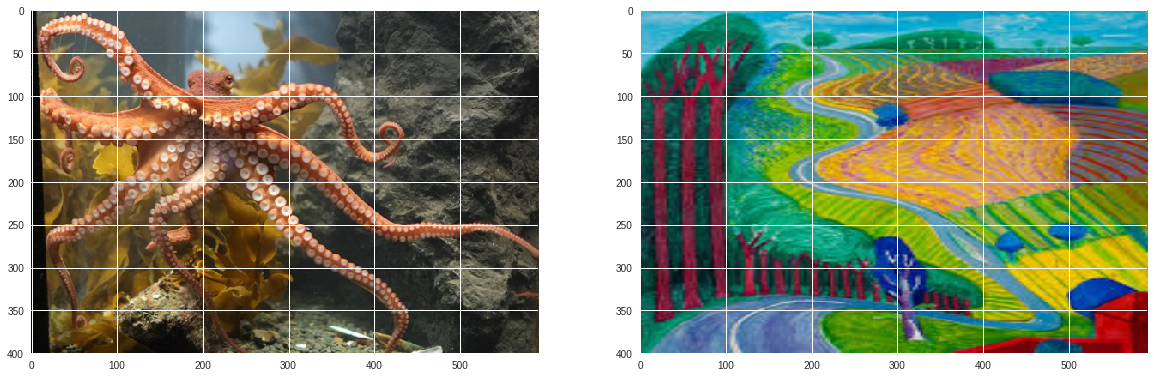

In [0]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

VGG19 Layers

Content and Style Features

In [0]:
def get_features(image, model, layers=None):
  ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
  ## Need the layers for the content and style representations of an image
  if layers is None:
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  ## content representation
              '28': 'conv5_1'}
        
  features = {}
  x = image
  # model._modules is a dictionary holding each module in the model
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x
            
  return features

Gram Matrix

In [0]:
def gram_matrix(tensor):
  # get the batch_size, depth, height, and width of the Tensor
  _, d, h, w = tensor.size()
  
  # reshape so we're multiplying the features for each channel
  tensor = tensor.view(d, h * w)
  
  # calculate the gram matrix
  gram = torch.mm(tensor, tensor.t())
    
  return gram

Putting it all Together

In [0]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

Loss and Weights

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Updating the Target & Calculating Losses

Total loss:  49114340.0


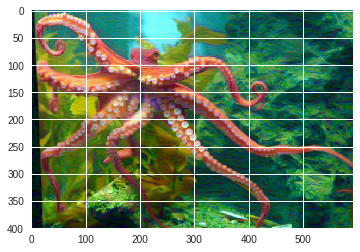

Total loss:  9946348.0


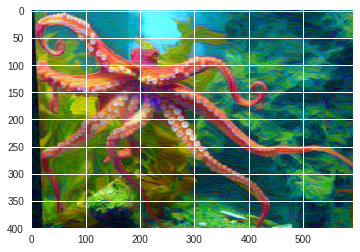

Total loss:  5176585.0


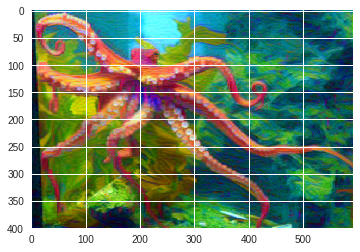

Total loss:  3147052.25


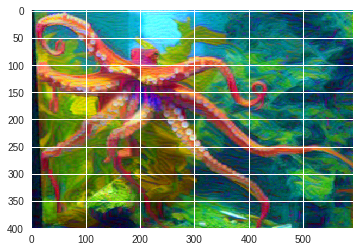

Total loss:  2024759.125


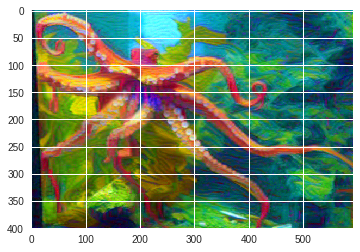

In [0]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
  # get the features from your target image
  target_features = get_features(target, vgg)
    
  # the content loss
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
  # the style loss
  # initialize the style loss to 0
  style_loss = 0
  # then add to it for each layer's gram matrix loss
  for layer in style_weights:
    # get the "target" style representation for the layer
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    # get the "style" style representation
    style_gram = style_grams[layer]
    # the style loss for one layer, weighted appropriately
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    # add to the style loss
    style_loss += layer_style_loss / (d * h * w)
        
  # calculate the *total* loss
  total_loss = content_weight * content_loss + style_weight * style_loss
    
  # update your target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
    
  # display intermediate images and print the loss
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()


Display the Target Image

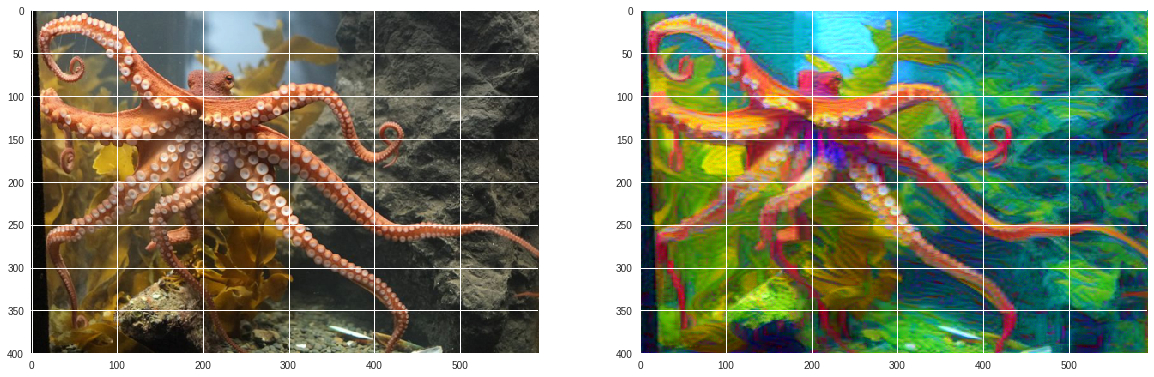

In [0]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

for more details visit this link 

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb